In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import resnet34
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
from PIL import Image
from torchvision.transforms import functional as f

In [5]:
model = resnet34(weights='ResNet34_Weights.IMAGENET1K_V1', progress=False, )

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(512, 3)
model = model.to(device)

## Ресайз, нормализация и аугментация

In [9]:
my_transform_train = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            transforms.RandomRotation((-10, 10)),
            transforms.RandomHorizontalFlip(p=0.5)            
        ]
)

my_transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))          
        ]
)

## Чтение файлов и применение трансформаций

In [13]:
train_dataset = ImageFolder(root='./afhq/train', transform=my_transform_train)

In [14]:
test_dataset = ImageFolder(root='./afhq/val', transform=my_transform_train)

## Объявление даталоадеров

In [15]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
num_epoch = 16
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)

## Функция потерь

In [17]:
def loss_function(preds, true):
    loss = nn.CrossEntropyLoss()
    return loss(preds, true)

In [23]:
all_train_losses = []
all_test_losses = []

## Обучение и визуализация обучения

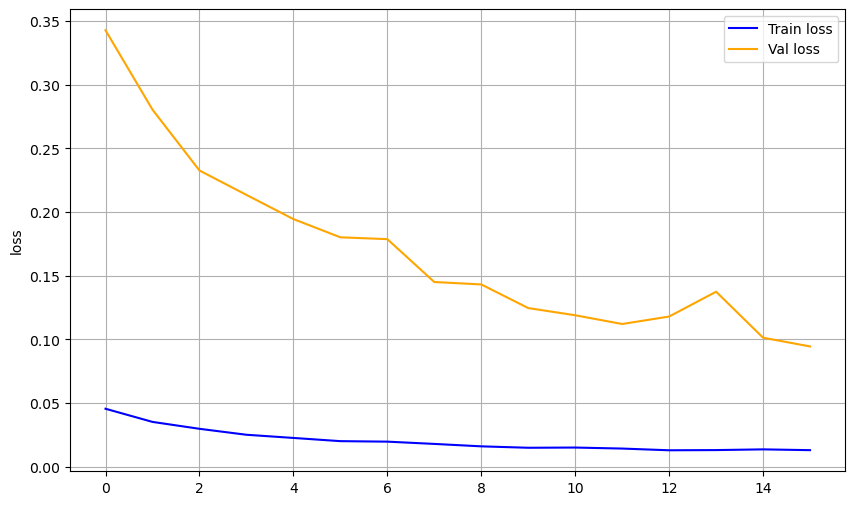

In [25]:
for epoch in range(num_epoch):
    train_loss = 0
    test_loss = 0
    model.train(True)
    print(f'epoch_number is {epoch}. Train')
    for (X, y) in tqdm(train_dataloader):
        model.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item() / (len(train_dataloader))
    model.eval()
    print(f'epoch_number is {epoch}. Test')
    for (X, y) in tqdm(train_dataloader):
        model.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        test_loss += loss.detach().item() / (len(test_dataloader))
    clear_output()
    all_train_losses.append(train_loss)
    all_test_losses.append(test_loss)    
    plt.figure(figsize=(10, 6))
    plt.plot(all_train_losses, label='Train loss', color='blue')
    plt.plot(all_test_losses, label='Val loss', color='orange')
    plt.legend()
    plt.ylabel('loss')
    plt.grid()
    plt.show()

In [26]:
print('train loss: ', train_loss)
print('test loss: ', test_loss)

train loss:  0.013032702888411126
test loss:  0.09446918130076182


## Вывод метрик модели

In [27]:
final_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [28]:
preds = []
real = []
for x, y in final_dataloader:
    preds.append(model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [29]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [30]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      0.99      0.99       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



## Предсказание на тексте

In [31]:
dict_names = {0:'Кошка', 1:'Собака', 2:'Дикая'}

In [37]:
def predict_by_path(path):
    image = Image.open(path)
    image_np = np.array(image)
    pred = model.forward(my_transform_train(image_np).to(device).unsqueeze(0)).cpu().detach().numpy()[0]
    plt.imshow(image)
    res = np.argmax(pred)
    print(dict_names[res])

Кошка


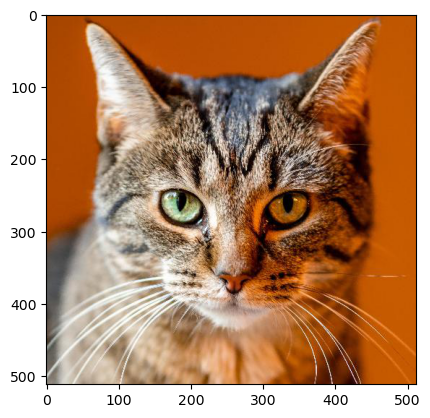

In [42]:
predict_by_path('./afhq/val/cat/flickr_cat_000191.jpg')

Собака


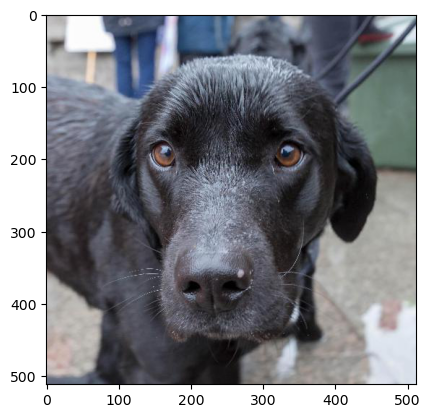

In [40]:
predict_by_path('./afhq/val/dog/flickr_dog_000694.jpg')

Дикая


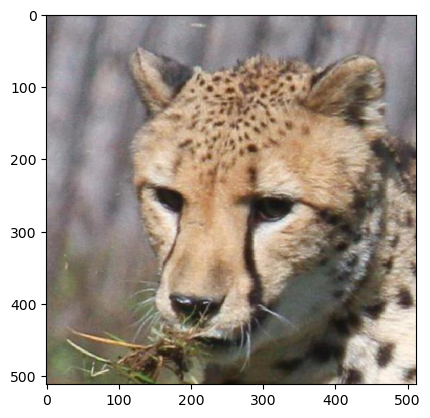

In [41]:
predict_by_path('./afhq/val/wild/flickr_wild_000731.jpg')